# Observational spatial analysis


In [1]:
%load_ext autoreload
%autoreload 2

import calendar
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import xarray as xr

from unseen import fileio, time_utils, eva
from acs_plotting_maps import cmap_dict, tick_dict  # NOQA

import spatial_plots

In [2]:
# Optional parameters
# (This cell is tagged "parameters")
dpi = 300
shapefile = None
shape_overlap = 0.1
alpha = 0.05
time_dim = "time"
lat_dim = "lat"
lon_dim = "lon"
similarity_test = "ks"
gev_relative_fit_test = "lrt"
time_agg = "maximum"

In [3]:
# Parameters
obs_name = "AGCD-CSIRO"
metric = "rx1day"
var = "pr"
reference_time_period = "1961-06-30 2023-06-30"
time_agg = "maximum"
covariate_base = 2025
gev_trend_period = "[1961, 2025]"
plot_dict = "dict(metric=\"Rx1day\", var=\"pr\", var_name=\"Precipitation\", units=\"mm day-1\", units_label=\"Precipitation [mm day-1]\", freq=\"YE-SEP\", cmap=cmap_dict[\"pr\"], cmap_anom=cmap_dict[\"pr_anom\"], ticks=np.arange(0, 280, 25), ticks_anom=np.arange(-100, 120, 20), ticks_anom_std=np.arange(-20, 25, 5), ticks_anom_pct=np.arange(-100, 120, 20), ticks_anom_ratio=np.arange(0, 2.2, 0.2), ticks_trend=np.arange(-50, 60, 10), ticks_param_trend={\"location\": np.arange(-2, 2.5, 0.5), \"scale\": np.arange(-0.5, 0.51, 0.1)}, cbar_extend=\"max\", agcd_mask=True)"
fig_dir = "/g/data/xv83/unseen-projects/outputs/rx1day/figures"
obs_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/rx1day_AGCD-CSIRO_r05_1901-2024_annual-oct-to-sep_aus.nc"
gev_params_nonstationary_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_rx1day_AGCD-CSIRO_r05_1901-2024_annual-oct-to-sep_aus.nc"
gev_params_nonstationary_drop_max_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_rx1day_AGCD-CSIRO_r05_1901-2024_annual-oct-to-sep_aus_drop_max.nc"
gev_params_best_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_bic_rx1day_AGCD-CSIRO_r05_1901-2024_annual-oct-to-sep_aus.nc"
gev_params_stationary_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_stationary_rx1day_AGCD-CSIRO_r05_1901-2024_annual-oct-to-sep_aus.nc"
shapefile = "/g/data/xv83/unseen-projects/outputs/rx1day/shapefiles/australia.shp"
shape_overlap = 0.1


In [4]:
# Required parameters
kwargs = locals()
assert "metric" in kwargs, "Must provide a metric name"
assert "var" in kwargs, "Must provide a variable name"
assert "obs_name" in kwargs, "Must provide a name"

if isinstance(reference_time_period, str):
    reference_time_period = list(reference_time_period.split(" "))

assert os.path.isfile(
    obs_file
), f"Must provide an observations data file (papermill option -p obs_file [filepath])"
assert os.path.isfile(
    gev_params_nonstationary_file
), f"Must provide a nonstationary GEV parameters file (papermill option -p gev_params_nonstationary_file [filepath])"

assert os.path.isfile(
    gev_params_nonstationary_drop_max_file
), f"Must provide a nonstationary GEV parameters file (papermill option -p gev_params_nonstationary_drop_max_file [filepath])"
assert (
    "covariate_base" in kwargs
), "Must provide a nonstationary GEV covariate base year"
assert (
    time_agg in spatial_plots.func_dict
), f"Invalid time aggregation method: {time_agg} (options: {list(spatial_plots.func_dict.keys())})"

# Format parameters passed as strings
assert (
    "gev_trend_period" in kwargs
), "Must provide a GEV trend period (e.g., '[1981, 2010]')"
if isinstance(gev_trend_period, str):
    # Convert string to list
    gev_trend_period = eval(gev_trend_period)
    print(f"gev_trend_period: {gev_trend_period}")

assert (
    "plot_dict" in kwargs
), "Must provide spatial plot dictionary of labels, ticks and colormaps"
if isinstance(plot_dict, str):
    # Convert string to dictionary and check for required keys
    plot_dict = eval(plot_dict)
    for key in [
        "metric",
        "var",
        "var_name",
        "units",
        "units_label",
        "freq",
        "cmap",
        "cmap_anom",
        "ticks",
        "ticks_anom",
        "ticks_anom_std",
        "ticks_anom_pct",
        "ticks_anom_ratio",
        "ticks_trend",
        "ticks_param_trend",
        "cbar_extend",
        "agcd_mask",
    ]:
        assert key in plot_dict, f"Missing key: {key} in plot_dict"

gev_trend_period: [1961, 2025]


In [5]:
fig_dir = f"{fig_dir}/acs"

### Open dataset of metric in observational data

In [6]:
obs_ds = fileio.open_dataset(obs_file, shapefile=shapefile, shape_overlap=shape_overlap)
obs_ds

<xarray.Dataset> Size: 29MB
Dimensions:     (time: 123, lat: 66, lon: 82)
Coordinates:
  * lat         (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon         (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * time        (time) object 984B 1901-09-30 00:00:00 ... 2023-09-30 00:00:00
    event_time  (time, lat, lon) <U10 27MB dask.array<chunksize=(123, 66, 82), meta=np.ndarray>
Data variables:
    pr          (time, lat, lon) float32 3MB dask.array<chunksize=(123, 66, 82), meta=np.ndarray>
Attributes: (12/34)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Fri Mar 14 15:17:30 2025: /g/data/xv83/as3...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...
    regrid_method:                 conservative

In [7]:
# Select reference time period (defined in metric config file)
if reference_time_period is not None:
    obs_ds = time_utils.select_time_period(obs_ds, reference_time_period)
obs_ds = obs_ds.dropna("time", how="all")
obs_ds

<xarray.Dataset> Size: 15MB
Dimensions:     (time: 62, lat: 66, lon: 82)
Coordinates:
  * lat         (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon         (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * time        (time) object 496B 1961-09-30 00:00:00 ... 2022-09-30 00:00:00
    event_time  (time, lat, lon) <U10 13MB dask.array<chunksize=(62, 66, 82), meta=np.ndarray>
Data variables:
    pr          (time, lat, lon) float32 1MB dask.array<chunksize=(62, 66, 82), meta=np.ndarray>
Attributes: (12/34)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Fri Mar 14 15:17:30 2025: /g/data/xv83/as3...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...
    regrid_method:                 conservative

In [8]:
# Convert event time strings to cftime objects
event_times = np.vectorize(time_utils.str_to_cftime)(
    obs_ds.event_time, obs_ds.time.dt.calendar
)
obs_ds["event_time"] = (obs_ds.event_time.dims, event_times)
obs_ds

<xarray.Dataset> Size: 4MB
Dimensions:     (time: 62, lat: 66, lon: 82)
Coordinates:
  * lat         (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon         (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * time        (time) object 496B 1961-09-30 00:00:00 ... 2022-09-30 00:00:00
    event_time  (time, lat, lon) object 3MB 1960-10-01 00:00:00 ... 2021-10-0...
Data variables:
    pr          (time, lat, lon) float32 1MB dask.array<chunksize=(62, 66, 82), meta=np.ndarray>
Attributes: (12/34)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Fri Mar 14 15:17:30 2025: /g/data/xv83/as3...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...
    regrid_method:                 conservative

In [9]:
obs_max_event = obs_ds[var].max().load().item()
obs_max_event_loc = (
    obs_ds[var].where(obs_ds[var].load() == obs_max_event, drop=True).squeeze()
)
obs_max_event_loc.load()

<xarray.DataArray 'pr' ()> Size: 4B
array(498.05243, dtype=float32)
Coordinates:
    lat         float64 8B -14.0
    lon         float64 8B 142.5
    time        object 8B 1985-09-30 00:00:00
    event_time  object 8B 1985-01-16 00:00:00
Attributes:
    standard_name:                 lwe_thickness_of_precipitation_amount
    long_name:                     Daily precipitation
    units:                         mm d-1
    cell_methods:                  time: sum
    analysis_version_number:       3.01
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    frequency:                     daily
    length_scale_for_analysis:     80.0
    analysis_time:                 2010-10-23 14:49:46 UTC
    original_name:                 precip

## Spatial Maps

In [10]:
# Store plot related variables
info = spatial_plots.InfoSet(
    name=obs_name,
    obs_name=obs_name,
    fig_dir=fig_dir,
    file=obs_file,
    obs_ds=obs_ds,
    **plot_dict,
)

# Plot year when record event occurred

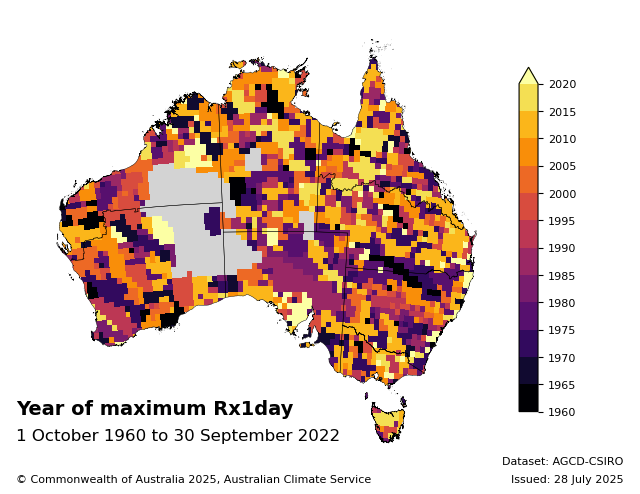

In [11]:
spatial_plots.plot_event_year(info, obs_ds, time_agg)

## Most common month of event

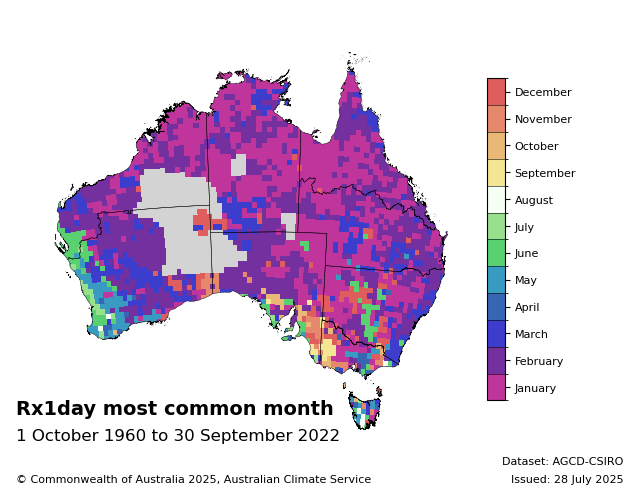

In [12]:
spatial_plots.plot_event_month_mode(info, obs_ds)

([<matplotlib.axis.XTick at 0x15330ee43a10>,
 [Text(1, 0, 'Jan'),
  Text(2, 0, 'Feb'),
  Text(3, 0, 'Mar'),
  Text(4, 0, 'Apr'),
  Text(5, 0, 'May'),
  Text(6, 0, 'Jun'),
  Text(7, 0, 'Jul'),
  Text(8, 0, 'Aug'),
  Text(9, 0, 'Sep'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Nov'),
  Text(12, 0, 'Dec')])

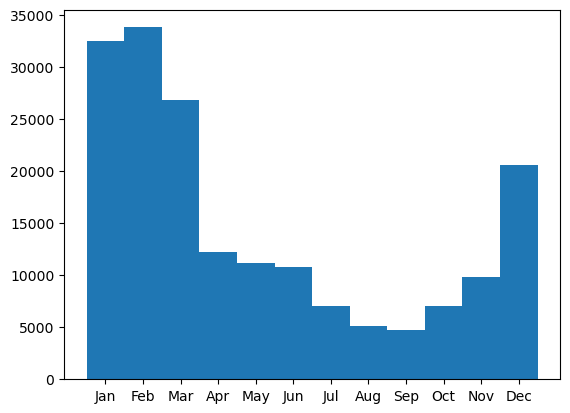

In [13]:
# Event month distribution (based on all grid points)
months = obs_ds.event_time.dt.month
months = xr.where(~np.isnan(obs_ds[var]), months, np.nan)
months.plot.hist(bins=np.arange(0.5, 13))
plt.xticks(np.arange(1, 13), [calendar.month_abbr[i] for i in range(1, 13)])


## Map of metric median

/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)


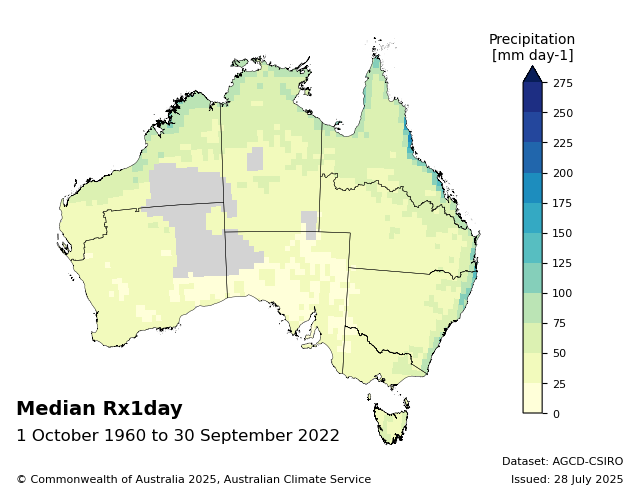

In [14]:
spatial_plots.plot_time_agg(info, obs_ds, "median")

# Map of metric maximum/minimum

/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)


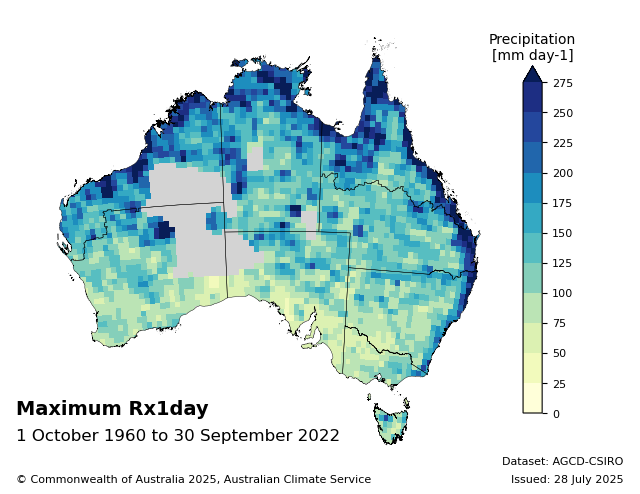

In [15]:
spatial_plots.plot_time_agg(info, obs_ds, time_agg)

# GEV analysis

In [16]:
# Load GEV parameters
covariate = obs_ds[time_dim].dt.year
times = xr.DataArray(gev_trend_period, dims="time")

In [17]:
dparams_ns = fileio.open_dataset(
    gev_params_nonstationary_file, shapefile=shapefile, shape_overlap=shape_overlap
)[var]

dparams_ns

<xarray.DataArray 'pr' (lat: 66, lon: 82, dparams: 5)> Size: 216kB
dask.array<getitem, shape=(66, 82, 5), dtype=float64, chunksize=(66, 82, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon      (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * dparams  (dparams) <U10 200B 'c' 'location_0' ... 'scale_0' 'scale_1'
Attributes:
    long_name:    Nonstationary genextreme parameters
    description:  Parameters of the nonstationary genextreme distribution
    method:       MLE
    estimator:    SCIPY_FITSTART
    scipy_dist:   genextreme
    units:

In [18]:
dparams_ns_drop_max = fileio.open_dataset(
    gev_params_nonstationary_drop_max_file,
    shapefile=shapefile,
    shape_overlap=shape_overlap,
)[var]

dparams_ns_drop_max

<xarray.DataArray 'pr' (lat: 66, lon: 82, dparams: 5)> Size: 216kB
dask.array<getitem, shape=(66, 82, 5), dtype=float64, chunksize=(66, 82, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 528B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon      (lon) float64 656B 113.0 113.5 114.0 114.5 ... 152.5 153.0 153.5
  * dparams  (dparams) <U10 200B 'c' 'location_0' ... 'scale_0' 'scale_1'
Attributes:
    long_name:    Nonstationary genextreme parameters
    description:  Parameters of the nonstationary genextreme distribution
    method:       MLE
    estimator:    SCIPY_FITSTART
    scipy_dist:   genextreme
    units:

# GEV parameters
### Non-stationary GEV parameters

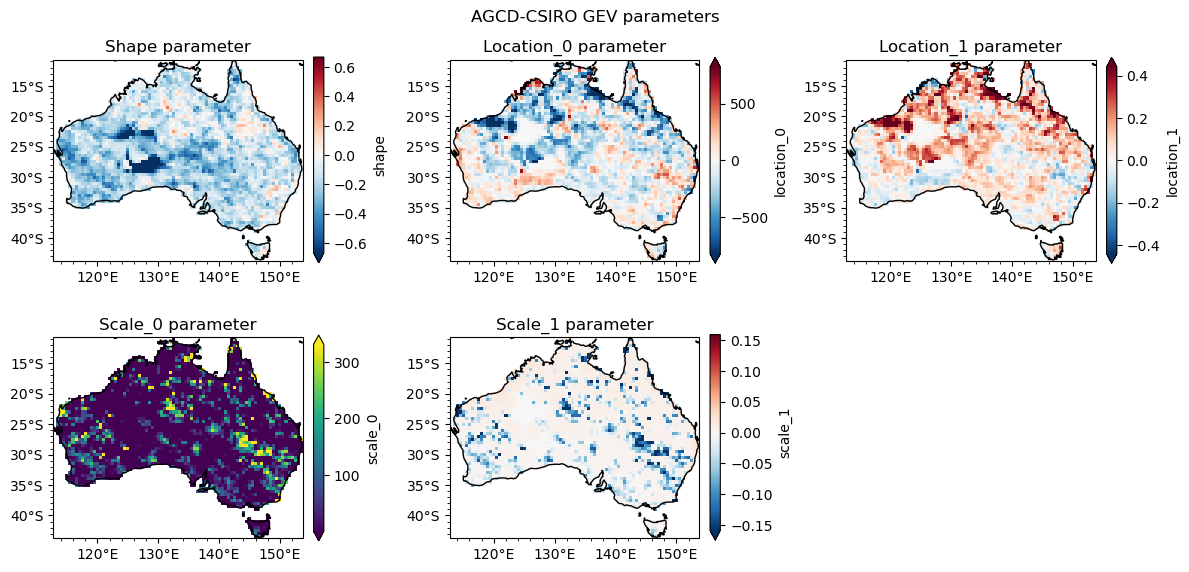

In [19]:
eva.spatial_plot_gev_parameters(
    dparams_ns,
    dataset_name=obs_name,
    outfile=f"{info.fig_dir}/gev_parameters_{info.filestem()}.png",
)

### Non-stationary GEV parameters (excluding maximum event)

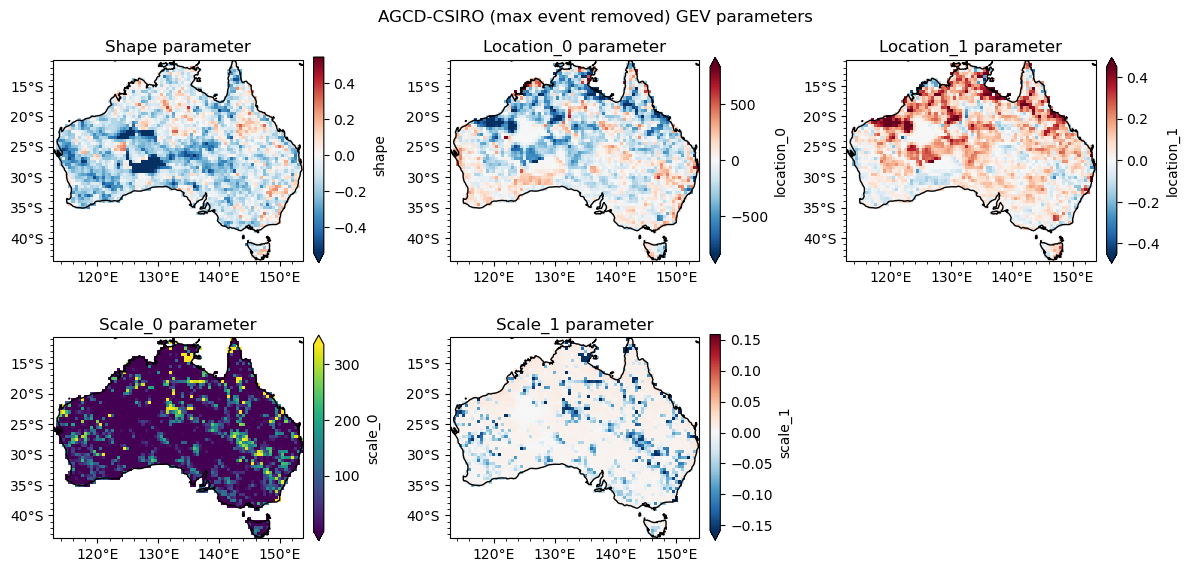

In [20]:
eva.spatial_plot_gev_parameters(
    dparams_ns_drop_max,
    dataset_name=obs_name + " (max event removed)",
    outfile=f"{info.fig_dir}/gev_parameters_drop_max_{info.filestem()}.png",
)

### Stationary GEV parameters

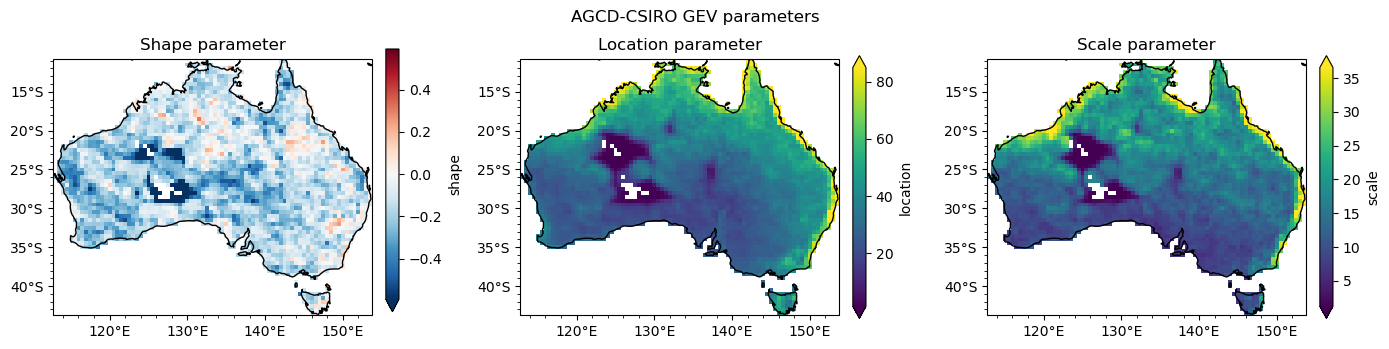

In [21]:
if Path(gev_params_stationary_file).exists():

    dparams_stationary = fileio.open_dataset(
        gev_params_stationary_file, shapefile=shapefile, shape_overlap=shape_overlap
    )[var]
    eva.spatial_plot_gev_parameters(
        dparams_stationary,
        dataset_name=obs_name,
        outfile=f"{info.fig_dir}/gev_parameters_stationary_{info.filestem()}.png",
    )

### Best of stationary and non-stationary GEV parameters (anomaly with respect to the non-stationary GEV parameters)

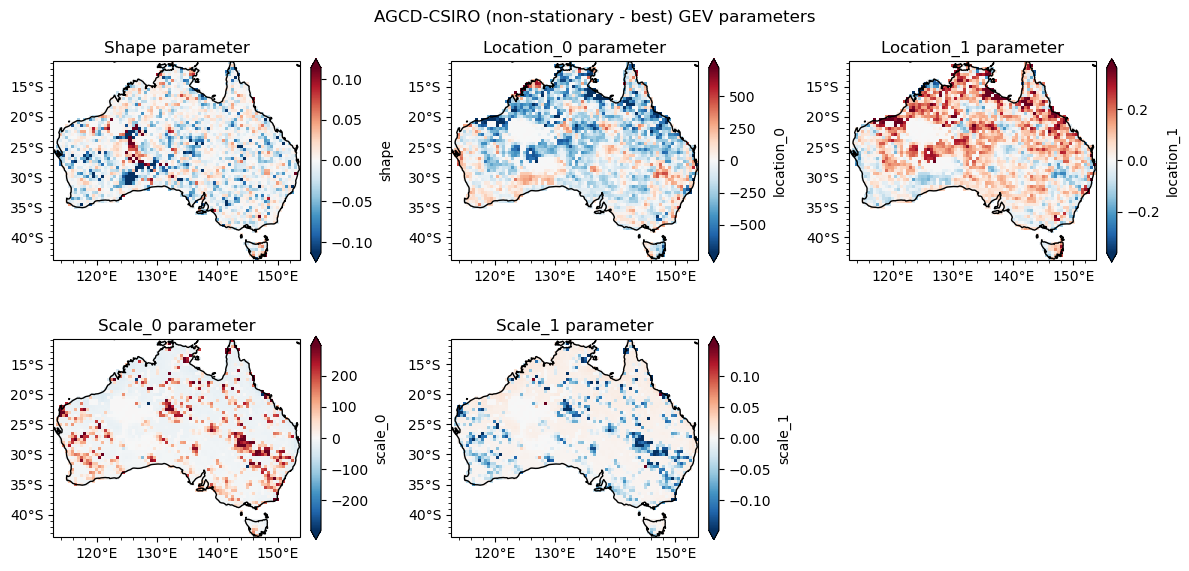

In [22]:
if Path(gev_params_best_file).exists():
    dparams_best = xr.open_dataset(gev_params_best_file)[var]
    dparams_diff = dparams_ns - dparams_best
    eva.spatial_plot_gev_parameters(
        dparams_diff,
        dataset_name=f"{obs_name} (non-stationary - best)",
        outfile=f"{info.fig_dir}/gev_parameters_best_diff_{info.filestem()}.png",
    )

### Plot GEV trend parameters

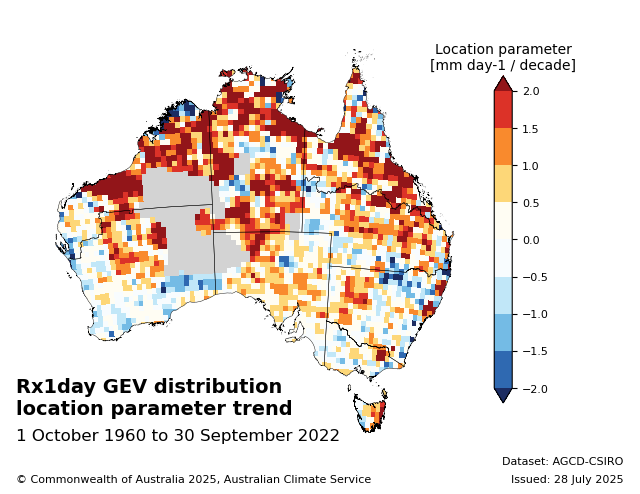

In [23]:
spatial_plots.plot_gev_param_trend(info, dparams_ns, "location")

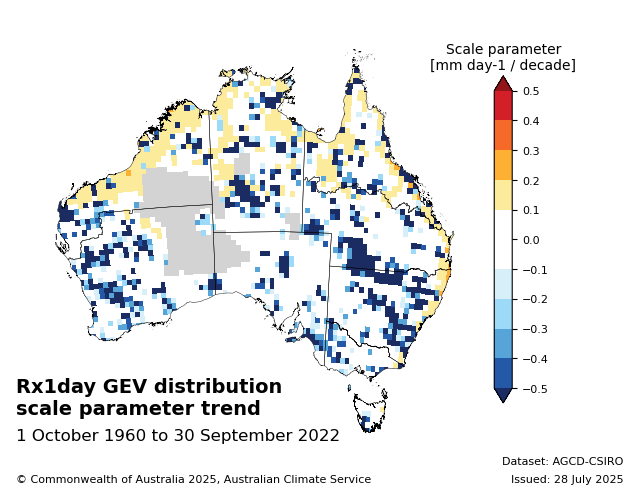

In [24]:
spatial_plots.plot_gev_param_trend(info, dparams_ns, "scale")

## Annual reccurence of observed max/min event

/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)


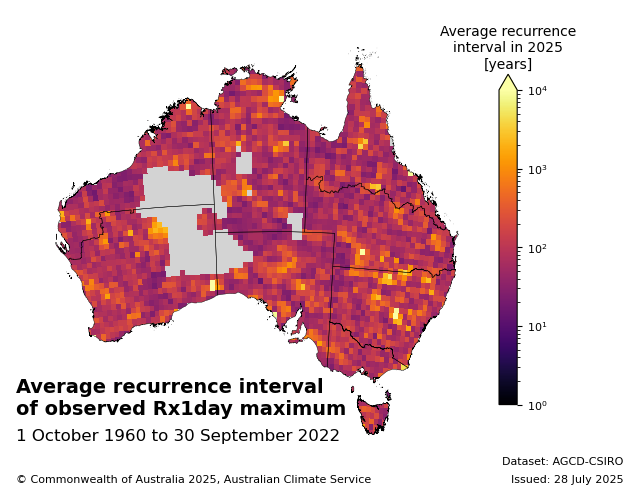

In [25]:
spatial_plots.plot_obs_ari(
    info,
    obs_ds,
    None,
    dparams_ns,
    covariate_base,
    time_agg=time_agg,
)

## Annual exceedance probability 
### GEV-based exceedance probability

In [26]:
# ARI: 10, 100, 1000 years (i.e., 10% AEP is equiv to a 1-in-10-year event)
aep = 1

### Plot of 1% AEP (1-in-100-year event) using the non-stationary GEV (past year, current year and the change per decade)

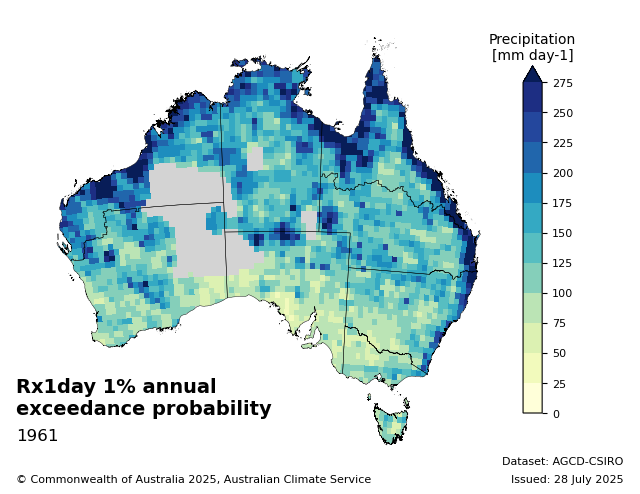

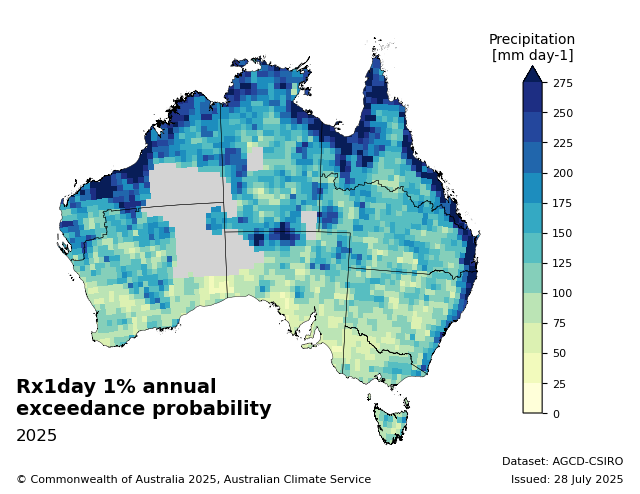

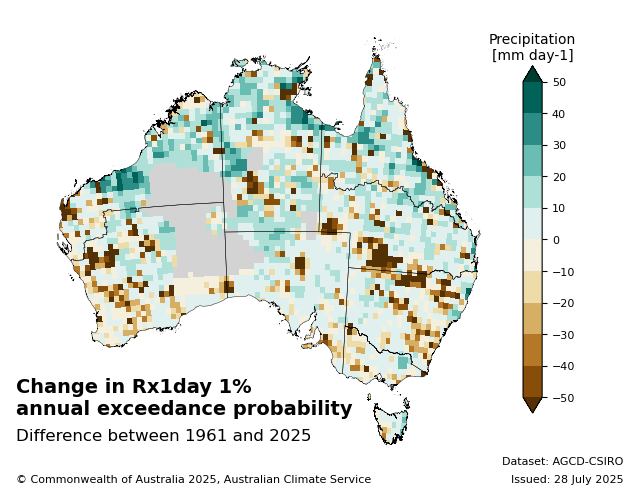

In [27]:
spatial_plots.plot_aep(
    info,
    dparams_ns,
    times,
    aep=aep,
)

## Probability of breaking the observed record

/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)


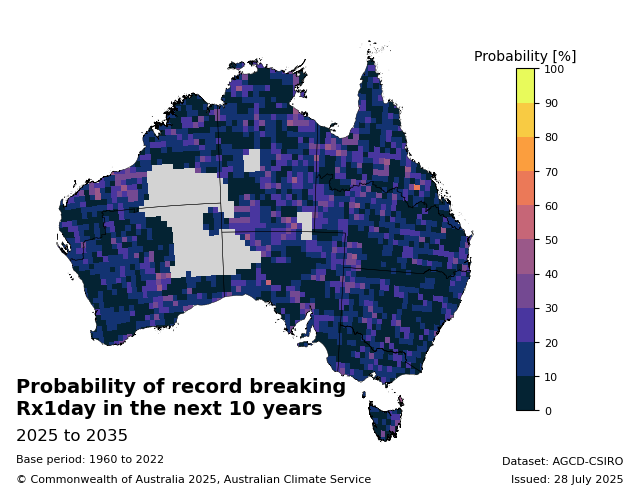

In [28]:
spatial_plots.plot_new_record_probability(
    info,
    obs_ds,
    None,
    dparams_ns,
    covariate_base,
    time_agg,
    n_years=10,
)

/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)


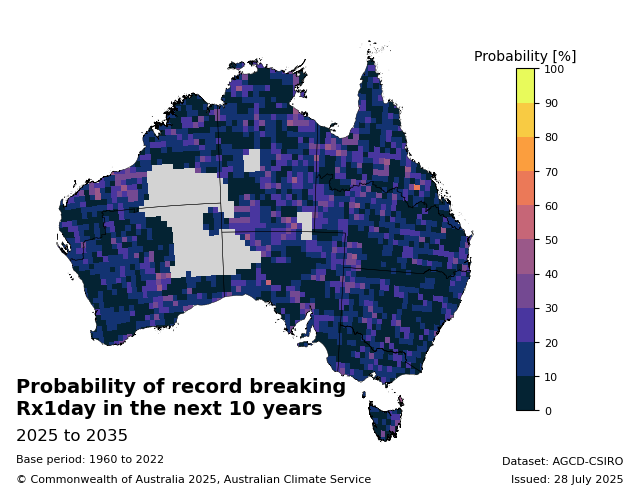

In [29]:
# Repeat for max event removed
info_copy = info.__copy__()  # Copy InfoSet object & update names
info_copy.long_name = f"{info.long_name} (max event removed)"
info_copy.file = info_copy.file.with_name(f"{info.filestem()}_drop_max.nc")

spatial_plots.plot_new_record_probability(
    info_copy,
    obs_ds,
    None,
    dparams_ns,
    covariate_base,
    time_agg,
    n_years=10,
)